In [1]:
from __future__ import unicode_literals, print_function, division
import pandas as pd
import numpy as np
import time
import math
import pickle

import matplotlib.pyplot as plt
#plt.switch_backend('agg')
import matplotlib.ticker as ticker
from prettytable import PrettyTable

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import  nltk.translate.bleu_score as bleu
from matplotlib.font_manager import FontProperties

from io import open
import unicodedata
import string
import re
import random
import warnings
warnings.filterwarnings("ignore")

In [2]:
from google.colab import files
uploaded = files.upload()

Saving Hindi_English_Truncated_Corpus.csv to Hindi_English_Truncated_Corpus.csv


In [87]:
df = pd.read_csv('Hindi_English_Truncated_Corpus.csv')
df = df.iloc[:,:2]
df.head()

,english_sentence,hindi_sentence
0,politicians do not have permission to do what ...,"राजनीतिज्ञों के पास जो कार्य करना चाहिए, वह कर..."
1,"I'd like to tell you about one such child,",मई आपको ऐसे ही एक बच्चे के बारे में बताना चाहू...
2,This percentage is even greater than the perce...,यह प्रतिशत भारत में हिन्दुओं प्रतिशत से अधिक है।
3,what we really mean is that they're bad at not...,हम ये नहीं कहना चाहते कि वो ध्यान नहीं दे पाते
4,.The ending portion of these Vedas is called U...,इन्हीं वेदों का अंतिम भाग उपनिषद कहलाता है।


In [88]:
pairs = [[f"{row['english_sentence']}", f"{row['hindi_sentence']}"] for index, row in df.iterrows()]
df = df.dropna()

In [89]:
# df = pd.DataFrame(data)

# Specify the column you want to write to the text file
column_name = 'english_sentence'

# Open a text file for writing
with open('english.txt', 'w') as file:
    # Iterate over the values in the specified column
    for value in df[column_name]:
        # Write each value followed by a newline character
        file.write(str(value) + '\n')


In [7]:
column_name = 'hindi_sentence'

# Open a text file for writing
with open('hindi.txt', 'w') as file:
    # Iterate over the values in the specified column
    for value in df[column_name]:
        # Write each value followed by a newline character
        file.write(str(value) + '\n')

In [8]:
# Open the text file for reading
with open('english.txt', 'r') as file:
    # Read all lines into a list
    lines = file.readlines()

# Print the contents of the file
i = 0
for line in lines:
    print(line.strip())  # .strip() removes trailing newline characters
    i += 1
    if i == 5:
      break

politicians do not have permission to do what needs to be done.
I'd like to tell you about one such child,
This percentage is even greater than the percentage in India.
what we really mean is that they're bad at not paying attention.
.The ending portion of these Vedas is called Upanishad.


In [9]:
with open('hindi.txt', 'r') as file:
    # Read all lines into a list
    lines = file.readlines()

# Print the contents of the file
i = 0
for line in lines:
    print(line.strip())  # .strip() removes trailing newline characters
    i += 1
    if i == 5:
      break

राजनीतिज्ञों के पास जो कार्य करना चाहिए, वह करने कि अनुमति नहीं है .
मई आपको ऐसे ही एक बच्चे के बारे में बताना चाहूंगी,
यह प्रतिशत भारत में हिन्दुओं प्रतिशत से अधिक है।
हम ये नहीं कहना चाहते कि वो ध्यान नहीं दे पाते
इन्हीं वेदों का अंतिम भाग उपनिषद कहलाता है।


In [10]:
# Initialize an empty string to store the file contents
input_lang = ''

# Open the text file for reading
with open('english.txt', 'r') as file:
    # Read the entire file contents and store them in input_lang
    input_lang = file.readlines()

# Now, input_lang contains the contents of the file
print(len(input_lang))

127607


In [11]:
from tokenizers import Tokenizer
from tokenizers.models import BPE
from tokenizers.trainers import BpeTrainer
from tokenizers.pre_tokenizers import Whitespace

# Initialize a tokenizer
tokenizer_eng = Tokenizer(BPE())
tokenizer_hin = Tokenizer(BPE())
# Initialize a pre-tokenizer
tokenizer_eng.pre_tokenizer = Whitespace()
tokenizer_hin.pre_tokenizer = Whitespace()

# Initialize a trainer
trainer = BpeTrainer(special_tokens=[
    "<PAD>",
    "<SOS>",
    "<EOS>",
    "<UNK>",
    "<BOS>",

])

# Training files
eng_text = ["english.txt"]
hin_text = ["hindi.txt"]
# Train the tokenizer
tokenizer_eng.train(eng_text, trainer)
tokenizer_hin.train(hin_text, trainer)

# Now you can encode text
encoded1 = tokenizer_eng.encode("Hello, world!")
print(encoded1.ids)
print(encoded1.tokens)

encoded2 = tokenizer_hin.encode("राजनीतिज्ञों के पास जो कार्य करना चाहिए, वह करने कि अनुमति नहीं है")
print(encoded2.ids)
print(encoded2.tokens)

[24804, 16, 521, 5]
['Hello', ',', 'world', '!']
[16424, 247, 629, 323, 538, 550, 634, 17, 385, 358, 261, 2230, 318, 248]
['राजनीतिज्ञों', 'के', 'पास', 'जो', 'कार्य', 'करना', 'चाहिए', ',', 'वह', 'करने', 'कि', 'अनुमति', 'नहीं', 'है']


In [12]:
eng_vocab = tokenizer_eng.get_vocab()
hin_vocab = tokenizer_hin.get_vocab()

In [85]:
pairs = [[tokenizer_eng.encode(row['english_sentence']).ids, tokenizer_hin.encode(row['hindi_sentence']).ids] for index, row in df.iterrows()]

In [81]:
from sklearn.model_selection import train_test_split
pairs_train, pairs_rest = train_test_split(pairs, test_size=0.2, random_state=42)

# Split the rest into validation and test sets
pairs_valid, pairs_test = train_test_split(pairs_rest, test_size=0.5, random_state=42)

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader

class MyDataset(Dataset):
    def __init__(self, pairs):
        self.pairs = pairs

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        input_data, target_data = self.pairs[idx]

        return torch.tensor(input_data), torch.tensor(target_data)


# Create an instance of MyDataset

# Define a collate function to pad sequences within a batch
def pad_collate(batch):
    input_seqs, target_seqs = zip(*batch)

    # Pad input sequences to the maximum length in the batch
    input_seqs_padded = torch.nn.utils.rnn.pad_sequence(input_seqs, batch_first=True)

    # Pad target sequences to the maximum length in the batch
    target_seqs_padded = torch.nn.utils.rnn.pad_sequence(target_seqs, batch_first=True)

    return input_seqs_padded, target_seqs_padded


dataset_tr = MyDataset(pairs_train)
dataset_val = MyDataset(pairs_valid)
dataset_te = MyDataset(pairs_test)
# Create a DataLoader
batch_size = 5  # Set your desired batch size
train_dataloader = DataLoader(dataset_tr, batch_size=batch_size, collate_fn=pad_collate)
test_dataloader = DataLoader(dataset_te, batch_size=batch_size, collate_fn=pad_collate)
valid_dataloader = DataLoader(dataset_val, batch_size=batch_size, collate_fn=pad_collate)
# Example usage of dataloader
j = 0
for batch_idx, (inputs, targets) in enumerate(train_dataloader):
    print("Batch:", batch_idx)
    print("Input shape:", inputs.shape)
    print("Target shape:", targets)
    j += 1
    if j == 1:
      break

In [25]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size,embedding_size, hidden_size,p, layers=1):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.layers = layers
        self.dropout = nn.Dropout(p)

        self.embedding = nn.Embedding(input_size, embedding_size)
        self.lstm = nn.LSTM(embedding_size, hidden_size, layers, batch_first=False, dropout = p, bidirectional = True)

        self.fc_hidden = nn.Linear(hidden_size * 2, hidden_size)
        self.fc_cell = nn.Linear(hidden_size * 2, hidden_size)
        print(type(self.dropout),type(self.embedding))

    def forward(self, x):

        print("input encoder ",x.shape)
        print("input encoder ",x)
        embedding = self.dropout(self.embedding(x))
        print("encoder embed shape ", embedding.shape)
        encoder_states, (hidden, cell) = self.lstm(embedding)
        print("encoder state in encoder ", encoder_states.shape)
        print("hidden in encoder ",hidden.shape)
        print("cell in encoder ", cell.shape)
        hidden = self.fc_hidden(torch.cat((hidden[0:1], hidden[1:2]), dim=2))
        cell = self.fc_cell(torch.cat((cell[0:1], cell[1:2]), dim=2))
        print("cat hidden in encoder ",hidden.shape)
        print("cat cell in encoder ", cell.shape)
        return encoder_states, hidden, cell



In [27]:
class DecoderRNN(nn.Module):
    def __init__(self,input_size, embedding_size, hidden_size, p, layers = 1 ):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, embedding_size)
        self.lstm = nn.LSTM(hidden_size*2+embedding_size , hidden_size,layers, dropout = p)

        self.energy = nn.Linear(hidden_size * 3, 1)
        self.fc = nn.Linear(hidden_size, input_size)

        self.dropout = nn.Dropout(p)
        self.softmax = nn.Softmax(dim=0)
        self.relu = nn.ReLU()
        print(type(self.dropout),type(self.embedding))

    def forward(self, x, encoder_states, hidden, cell):
        ## CODE CHANGED
        print("x value in decoder ",x)
        print("encoder state ",encoder_states.shape)

        # print(x,encoder_states.shape,hidden.shape,cell.shape)
        ## CODE CHANGED
        x = x.unsqueeze(0)
        # x -> (1, N)
        print("size of x in decoder ",x.shape)
        embeddings = self.dropout(self.embedding(x))
        # embeddings -> (1, N, embed_size)
        print("embeddings ",embeddings.shape)
        sequence_length = encoder_states.shape[0]
        print("sequence_length ",sequence_length)
        h_reshaped = hidden.repeat(sequence_length,1,1)
        # h_reshape -> (seq_length, N, hidden )
        print("h_rshape ",h_reshaped.shape)

        energy = self.relu(self.energy(torch.cat((h_reshaped,encoder_states), dim =2)))
        # energy = self.relu(self.energy(torch.cat((h_reshaped,encoder_states), dim =2)))
        # energy -> (seq_length, N, 1)
        print("print shape ", energy.shape)
        attention = self.softmax(energy)
        # attention = self.softmax(energy.transpose(0, 1))
        # attension -> (seq_length, N, 1)
        print("attension shape ", attention.shape)
        weighted_states = attention  * encoder_states
        context_vector = torch.sum(weighted_states, dim=1)

        print("shape of weight vector ",weighted_states.shape)
        # context_vector = torch.matmul(attention.transpose(1, 2), encoder_states)
        # context_vector = context_vector.squeeze(1)
        embeddings = embeddings.expand(context_vector.shape[0], -1)

        print("context vector shape ", context_vector.shape)
        # rnn_input = torch.cat((context_vector, embeddings), dim=2)
        rnn_input = torch.cat((context_vector, embeddings), dim=1)

        outputs, (hidden, cell) = self.lstm(rnn_input, (hidden, cell))
        # outputs shape: (1, N, hidden_size)

        predictions = self.fc(outputs).squeeze(0)

        return predictions, hidden, cell

In [28]:
class Seq2seq(nn.Module):
    def __init__(self,encoder, decoder):
        super(Seq2seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, source, target, teacher_force_ratio = 0.7):
        batch_size = source.shape[0]
        target_len = target.shape[1]
        # target = target.transpose(0, 1)
        target_vocab_size = len(hin_vocab)
        print("source shape ",source.shape)
        print("source target ",target.shape)
        print("target length ", target_len)

        outputs = torch.zeros(target_len, batch_size, target_vocab_size).to(device)
        encoder_states, hidden, cell = self.encoder(source)

        x = target[0]
        print("x in seq2seq ", x)
        print("x in seq2seq ", x.shape)
        for t in range(0, target_len):
            # At every time step use encoder_states and update hidden, cell
            output, hidden, cell = self.decoder(x[t], encoder_states, hidden, cell)

            # Store prediction for current time step
            outputs[t] = output
            # Get the best word the Decoder predicted (index in the vocabulary)
            best_guess = output.argmax(1)

            x = target[t] if random.random() < teacher_force_ratio else best_guess

        return outputs

In [29]:
from tqdm import tqdm
from torchtext.data.metrics import bleu_score

In [30]:
class RNNTrainer:
    """
    RNNTrainer wraps RNN_LM to handle training and evaluation.

    """

    def __init__(
        self,
        model,
        optimizer,
        criterion,
        train_dataloader,
        valid_dataloader,
        epochs,
        use_cuda,
        eng_vocab,
        # hin_vocab,
        model_dir
    ):

        self.model = model,
        self.epochs = epochs
        self.optimizer = optimizer
        self.criterion = criterion
        self.train_dataloader = train_dataloader
        self.valid_dataloader = valid_dataloader
        self.use_cuda = use_cuda
        self.model_dir = model_dir
        self.loss = {"train": [], "val": []}
        self.eng_vocab = eng_vocab
        self.hin_vocab = hin_vocab


        # Move the model to GPU if available
        if self.use_cuda:
            self.model = self.model.cuda()

    def train(self):
        """
        Trains the model with train_dataloader and validates using valid_dataloader

        """
        # You may change the input arguments to this function,
        # but make sure to also change the code wherever this function is called

        # ADD YOUR CODE HERE FOR TRAINING & VALIDATION

        best_val_loss = float('inf')
        patience = 10
        no_impr_counter = 0


        for epoch in tqdm(range(self.epochs)):
          loss_train = self.train_model()
          loss_val = self.test_model()

          print(f"epoch number : {epoch+1}, training loss : {loss_train}, validation loss : {loss_val}")

          if loss_val < best_val_loss:
                best_val_loss = loss_val
                no_impr_counter = 0
                self.save_model()
          else:
            no_impr_counter += 1

          if(no_impr_counter>patience):
               print(f"early stopping at epoch {epoch+1} since no improvement from last {patience} epoch")
               break;


    def train_model(self):
          epoch_loss = 0
          j = 0
          self.model = model
          model.train()

          for input, target in self.train_dataloader:
              if self.use_cuda:
                    input, target = input.cuda(), target.cuda()

              print("input_shape in seq2seq ",input.shape)
              output = self.model(input, target)

              output = output[1:].reshape(-1, output.shape[2])
              target = target[1:].reshape(-1)

              self.optimizer.zero_grad()
              loss = self.criterion(output, target)

              # print(loss_value)
              loss.backward()
              loss_value = loss.item()
              torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1)

              self.optimizer.step()
              epoch_loss += loss_value
              j+=1

          self.loss["train"].append(epoch_loss/j)
          torch.cuda.empty_cache()

          return epoch_loss/j

    def test_model(self ):
          epoch_loss = 0
          j = 0
          self.model_seq2seq.eval()
          # batch_size = targets.size(0)

          for input, target in (self.valid_dataloader):
              if self.use_cuda:
                    input, target = input.cuda(), target.cuda()

              output = self.model_seq2seq(input)
              output = output[1:].reshape(-1, output.shape[2])
              target = target[1:].reshape(-1)

              loss = self.criterion(output, target)
              loss_value = loss.item()
              epoch_loss += loss_value
              j+=1

          self.loss["val"].append(epoch_loss/j)
          torch.cuda.empty_cache()
          return epoch_loss/j

    def save_model(self):
        """
        Save final model to directory

        """

        model_path = os.path.join(self.model_dir, "model.pt")
        torch.save(self.model, model_path)

    def save_checkpoint(state, filename="my_checkpoint.pth.tar"):
        print("=> Saving checkpoint")
        torch.save(state, filename)


    def bleu(data, model, german, english, device):
       targets = []
       outputs = []

       for example in data:
         src = vars(example)["src"]
         trg = vars(example)["trg"]

         prediction = translate_sentence(model, src, german, english, device)
         prediction = prediction[:-1]  # remove <eos> token

         targets.append([trg])
         outputs.append(prediction)

       return bleu_score(outputs, targets)

    def save_loss(self):
        """
        Save train/val loss as json file to the directory

        """

        loss_path = os.path.join(self.model_dir, "loss.json")
        with open(loss_path, "w") as fp:
            json.dump(self.loss, fp)

In [31]:
MAX_LENGTH = 20

# Remember to fix seed as 42
torch.manual_seed(42)

# check if GPU is available
USE_CUDA = torch.cuda.is_available()
print(f"GPU is available: {USE_CUDA}")

batch_size = 32
SHUFFLE = True# if dataset should be shuffled



GPU is available: False


In [32]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

input_size_encoder = len(eng_vocab)
encoder_embedding_size = 200
hidden_size = 200
num_layers = 1
enc_dropout = 0.3

input_size_decoder = len(hin_vocab)
decoder_embedding_size = 250
dec_dropout = 0.3

encoder_net = EncoderRNN(input_size_encoder, encoder_embedding_size, hidden_size, enc_dropout, num_layers).to(device)
decoder_net = DecoderRNN( input_size_decoder, decoder_embedding_size, hidden_size, dec_dropout, num_layers).to(device)

model = Seq2seq(encoder_net, decoder_net).to(device)


<class 'torch.nn.modules.dropout.Dropout'> <class 'torch.nn.modules.sparse.Embedding'>
<class 'torch.nn.modules.dropout.Dropout'> <class 'torch.nn.modules.sparse.Embedding'>


In [33]:
learning_rate = 0.01
EPOCHS = 20

optimizer = optim.Adam(model.parameters(), lr=learning_rate)

pad_idx = 0
criterion = nn.CrossEntropyLoss(ignore_index=pad_idx)

In [34]:
model_dir = 'suprit_22838/rnn'

# if not os.path.exists(model_dir):
#     os.makedirs(model_dir)

# NOTE: if you are **optionally** using additional options for the trainer
# (e.g., a training scheduler), please add them below.
trainer = RNNTrainer(
        model=model,
        optimizer=optimizer,
        criterion=criterion,
        train_dataloader=train_dataloader,
        valid_dataloader=valid_dataloader,
        epochs=EPOCHS,
        use_cuda=USE_CUDA,
        eng_vocab = eng_vocab,
        model_dir=model_dir
        )

# Train the model
trainer.train()
print("Training finished.")

trainer.save_model()
trainer.save_loss()

  0%|          | 0/20 [00:00<?, ?it/s]

input_shape in seq2seq  torch.Size([5, 37])
source shape  torch.Size([5, 37])
source target  torch.Size([5, 49])
target length  49
input encoder  torch.Size([5, 37])
input encoder  tensor([[  980,   741,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0],
        [  943,  1786,   524,   203,  6672,  3168,   234,   577,    16, 14961,
           245,   285, 29473, 29612,    16,   203,  3257, 18690,   200,   245,
          2848,   324,   273,   186,  2834,    16,   602,   200,  2985,   204,
          6098,  5038,   194,   599,   200,  2407,    18],
        [  185,  1439,   186,  2164,   194, 16763,   233,   496,    17,   540,
           191,  1289,   302,  2323,   204,  2407,   273, 10996,    80,   839,
          1751,   200,  1278,   200,  1099,   186,  2407,    18,     

  0%|          | 0/20 [00:00<?, ?it/s]

encoder state in encoder  torch.Size([5, 37, 400])
hidden in encoder  torch.Size([2, 37, 200])
cell in encoder  torch.Size([2, 37, 200])
cat hidden in encoder  torch.Size([1, 37, 200])
cat cell in encoder  torch.Size([1, 37, 200])
x in seq2seq  tensor([930,  31, 867,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0])
x in seq2seq  torch.Size([49])
x value in decoder  tensor(930)
encoder state  torch.Size([5, 37, 400])
size of x in decoder  torch.Size([1])
embeddings  torch.Size([1, 250])
sequence_length  5
h_rshape  torch.Size([5, 37, 200])
print shape  torch.Size([5, 37, 1])
attension shape  torch.Size([5, 37, 1])
shape of weight vector  torch.Size([5, 37, 400])
context vector shape  torch.Size([5, 400])


RuntimeError: For unbatched 2-D input, hx and cx should also be 2-D but got (3-D, 3-D) tensors

========== Building Encoder... ==========

EncoderRNN(
  (embedding): Embedding(66550, 100, padding_idx=1)
  (lstm): LSTM(100, 100)
)


+-------------------+------------+
|      Modules      | Parameters |
+-------------------+------------+
|  embedding.weight |  6655000   |
| lstm.weight_ih_l0 |   40000    |
| lstm.weight_hh_l0 |   40000    |
|  lstm.bias_ih_l0  |    400     |
|  lstm.bias_hh_l0  |    400     |
+-------------------+------------+
Total Trainable Params: 6735800


========== Building Decoder... ==========

AttnDecoderRNN(
  (embedding): Embedding(49371, 100)
  (attn): Linear(in_features=200, out_features=20, bias=True)
  (attn_combine): Linear(in_features=200, out_features=100, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (lstm): LSTM(100, 100)
  (out): Linear(in_features=100, out_features=49371, bias=True)
)


+---------------------+------------+
|       Modules       | Parameters |
+---------------------+------------+
|   embedding.weight  |  4937100   |
| 

<Figure size 640x480 with 0 Axes>

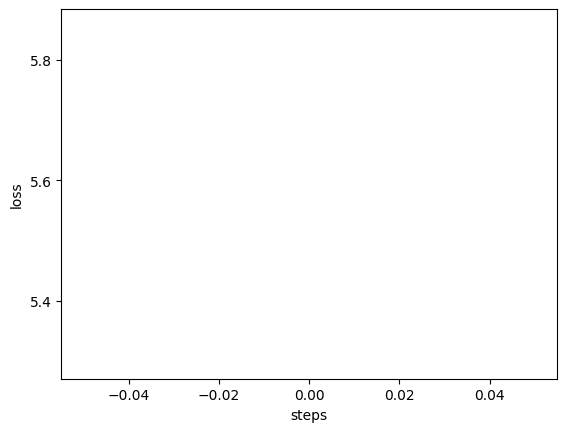

========== Finished Training... ==========



In [54]:
encoder1, attn_decoder1 = run_training()

In [61]:
evaluateRandomly(encoder1, attn_decoder1)

> The average age of a circus elephant is about 35 years .
= सर्कस के हाथी की औसत उम्र 35 वर्ष होती है .
< <EOS>
BLEU Score 0

> so I wrote about this and had it translated
= इसलिए मैने इसके बारे में लिखा, और इसका चीनी में अनुवाद करवाया
< <EOS>
BLEU Score 0

> But Hitler is not so mere interested in subject of India.
= लेकिन हिटलर को भारत के विषय में विशेष रूची नहीं थी।
< <EOS>
BLEU Score 0

> all those problems.
= इस तरह की समस्याएँ |
< <EOS>
BLEU Score 0

> We stop for a quick commercial break,
= हम एक छोटे से कमर्शियल ब्रेक के लिए रुकेंगे,
< <EOS>
BLEU Score 0

> So, I'll start with this:
= तो, मैं इससे शुरूआत करूँगी :
< <EOS>
BLEU Score 0

> On top of this building there is a big tomb
= इस इमारत के ऊपर एक वृहत गुम्बद सुशोभित है।
< <EOS>
BLEU Score 0

> Karna : son of Kunti and Suryadev and eldest brother of Pandavas.
= कर्ण : सूर्यदेव एवमं कुन्ती के पुत्र और पाण्डवों के सबसे बड़े भाई।
< <EOS>
BLEU Score 0

> of shame and fear
= शर्म और डर के
< <EOS>
BLEU Score 0

> in remembrance o